#📌 Extracción

In [7]:
# Instalación de librerías (ejecutar solo la primera vez)
!pip install requests pandas matplotlib seaborn plotly

# Importación de librerías
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# Configuración de visualización
plt.style.use('default')
sns.set_palette("husl")
pd.set_option('display.max_columns', None)

# EXTRACCIÓN DE DATOS

print("🔄 Iniciando extracción de datos...")

# URL de la API
url = "https://raw.githubusercontent.com/ingridcristh/challenge2-data-science-LATAM/main/TelecomX_Data.json"

try:
    # Realizar petición HTTP
    response = requests.get(url)
    response.raise_for_status()

    # Cargar datos JSON
    data = response.json()
    print(f"✅ Datos extraídos exitosamente. Total de registros: {len(data)}")

except requests.RequestException as e:
    print(f"❌ Error al extraer datos: {e}")
    raise

🔄 Iniciando extracción de datos...
✅ Datos extraídos exitosamente. Total de registros: 7267


#🔧 Transformación

In [8]:
print("\n🔄 Iniciando transformación de datos...")

def normalize_json_data(data):
    """
    Normaliza los datos JSON anidados en un DataFrame plano
    """
    normalized_data = []

    for record in data:
        flat_record = {}

        # Campos principales
        flat_record['customerID'] = record.get('customerID', '')
        flat_record['Churn'] = record.get('Churn', '')

        # Datos del cliente
        customer = record.get('customer', {})
        flat_record['gender'] = customer.get('gender', '')
        flat_record['SeniorCitizen'] = customer.get('SeniorCitizen', 0)
        flat_record['Partner'] = customer.get('Partner', '')
        flat_record['Dependents'] = customer.get('Dependents', '')
        flat_record['tenure'] = customer.get('tenure', 0)

        # Servicios telefónicos
        phone = record.get('phone', {})
        flat_record['PhoneService'] = phone.get('PhoneService', '')
        flat_record['MultipleLines'] = phone.get('MultipleLines', '')

        # Servicios de internet
        internet = record.get('internet', {})
        flat_record['InternetService'] = internet.get('InternetService', '')
        flat_record['OnlineSecurity'] = internet.get('OnlineSecurity', '')
        flat_record['OnlineBackup'] = internet.get('OnlineBackup', '')
        flat_record['DeviceProtection'] = internet.get('DeviceProtection', '')
        flat_record['TechSupport'] = internet.get('TechSupport', '')
        flat_record['StreamingTV'] = internet.get('StreamingTV', '')
        flat_record['StreamingMovies'] = internet.get('StreamingMovies', '')

        # Información de la cuenta
        account = record.get('account', {})
        flat_record['Contract'] = account.get('Contract', '')
        flat_record['PaperlessBilling'] = account.get('PaperlessBilling', '')
        flat_record['PaymentMethod'] = account.get('PaymentMethod', '')

        # Cargos
        charges = account.get('Charges', {})
        flat_record['Charges.Monthly'] = charges.get('Monthly', 0)
        flat_record['Charges.Total'] = charges.get('Total', 0)

        normalized_data.append(flat_record)

    return pd.DataFrame(normalized_data)

# Normalizar datos
df = normalize_json_data(data)
print(f"✅ Datos normalizados exitosamente. Forma del DataFrame: {df.shape}")

# Mostrar información básica del dataset
print("\n📊 Información básica del dataset:")
print(f"Filas: {df.shape[0]}")
print(f"Columnas: {df.shape[1]}")
print(f"\nColumnas disponibles:")
for i, col in enumerate(df.columns, 1):
    print(f"{i:2d}. {col}")

# EXPLORACIÓN INICIAL DE DATOS

print("\n🔄 Explorando la estructura de los datos...")

# Información detallada del DataFrame
print("\n📋 Información detallada:")
df.info()

print("\n🔍 Tipos de datos:")
print(df.dtypes)

print("\n📈 Estadísticas descriptivas (variables numéricas):")
print(df.describe())

# LIMPIEZA Y CORRECCIÓN DE DATOS

print("\n🔄 Iniciando limpieza de datos...")

# 1. Verificar valores nulos
print("\n❓ Valores nulos por columna:")
null_values = df.isnull().sum()
print(null_values[null_values > 0])

# 2. Verificar duplicados
duplicates = df.duplicated().sum()
print(f"\n🔄 Duplicados encontrados: {duplicates}")

# 3. Verificar valores únicos en variables categóricas
print("\n🔍 Valores únicos en variables categóricas:")
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    unique_vals = df[col].unique()
    print(f"\n{col}: {unique_vals}")

# 4. Corrección de inconsistencias
print("\n🔧 Corrigiendo inconsistencias...")

# Convertir variables categóricas a formato consistente
binary_cols = ['Churn', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling']
service_cols = ['MultipleLines', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection',
                'TechSupport', 'StreamingTV', 'StreamingMovies']

# Limpiar espacios y estandarizar texto
for col in categorical_cols:
    if col in df.columns:
        df[col] = df[col].astype(str).str.strip().str.title()

# Manejar valores 'No phone service' y 'No internet service'
for col in service_cols:
    if col in df.columns:
        df[col] = df[col].replace('No Phone Service', 'No')
        df[col] = df[col].replace('No Internet Service', 'No')

# Convertir variables numéricas
numeric_cols = ['Charges.Monthly', 'Charges.Total', 'tenure']
for col in numeric_cols:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

print("✅ Limpieza completada")

# CREACIÓN DE COLUMNA CUENTAS DIARIAS

print("\n🔄 Creando columna Cuentas_Diarias...")

# Calcular cuentas diarias (asumiendo 30 días por mes)
df['Cuentas_Diarias'] = df['Charges.Monthly'] / 30
print(f"✅ Columna 'Cuentas_Diarias' creada exitosamente")

# ESTANDARIZACIÓN Y TRANSFORMACIÓN (OPCIONAL)

print("\n🔄 Estandarizando datos...")

# Crear copia del DataFrame para transformaciones
df_transformed = df.copy()

# Convertir variables binarias a numéricas (0/1)
binary_mapping = {'No': 0, 'Yes': 1}

for col in binary_cols:
    if col in df_transformed.columns:
        df_transformed[f'{col}_Binary'] = df_transformed[col].map(binary_mapping)

# Crear variables dummy para categorías principales
categorical_transform = ['gender', 'Contract', 'PaymentMethod', 'InternetService']
for col in categorical_transform:
    if col in df_transformed.columns:
        dummies = pd.get_dummies(df_transformed[col], prefix=col)
        df_transformed = pd.concat([df_transformed, dummies], axis=1)

print("✅ Transformación completada")


🔄 Iniciando transformación de datos...
✅ Datos normalizados exitosamente. Forma del DataFrame: (7267, 21)

📊 Información básica del dataset:
Filas: 7267
Columnas: 21

Columnas disponibles:
 1. customerID
 2. Churn
 3. gender
 4. SeniorCitizen
 5. Partner
 6. Dependents
 7. tenure
 8. PhoneService
 9. MultipleLines
10. InternetService
11. OnlineSecurity
12. OnlineBackup
13. DeviceProtection
14. TechSupport
15. StreamingTV
16. StreamingMovies
17. Contract
18. PaperlessBilling
19. PaymentMethod
20. Charges.Monthly
21. Charges.Total

🔄 Explorando la estructura de los datos...

📋 Información detallada:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7267 entries, 0 to 7266
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7267 non-null   object 
 1   Churn             7267 non-null   object 
 2   gender            7267 non-null   object 
 3   SeniorCitizen     7267 non-null   int64  
 4   

#📊 Carga y análisis


🔄 Iniciando análisis descriptivo...

📊 ANÁLISIS DESCRIPTIVO GENERAL

📈 Estadísticas descriptivas:
       SeniorCitizen   tenure  Charges.Monthly  Charges.Total  Cuentas_Diarias
count        7267.00  7267.00          7267.00        7256.00          7267.00
mean            0.16    32.35            64.72        2280.63             2.16
std             0.37    24.57            30.13        2268.63             1.00
min             0.00     0.00            18.25          18.80             0.61
25%             0.00     9.00            35.42         400.22             1.18
50%             0.00    29.00            70.30        1391.00             2.34
75%             0.00    55.00            89.88        3785.30             3.00
max             1.00    72.00           118.75        8684.80             3.96

📊 DISTRIBUCIÓN DE EVASIÓN

Distribución absoluta:
Churn
No     5174
Yes    1869
        224
Name: count, dtype: int64

Distribución porcentual:
Churn
No     71.20
Yes    25.72
        3.08


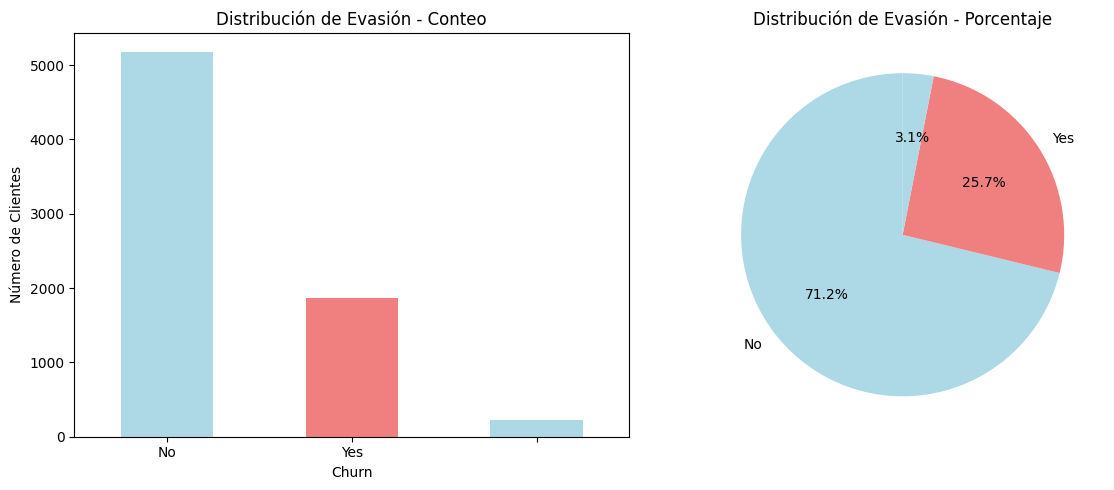


📊 ANÁLISIS DE EVASIÓN POR VARIABLES CATEGÓRICAS

🔍 gender:
Conteo absoluto:
Churn          No   Yes   All
gender                       
Female  104  2549   939  3592
Male    120  2625   930  3675
All     224  5174  1869  7267

Porcentaje por fila:
Churn            No    Yes
gender                    
Female  2.90  70.96  26.14
Male    3.27  71.43  25.31

🔍 SeniorCitizen:
Conteo absoluto:
Churn                 No   Yes   All
SeniorCitizen                       
0              184  4508  1393  6085
1               40   666   476  1182
All            224  5174  1869  7267

Porcentaje por fila:
Churn                   No    Yes
SeniorCitizen                    
0              3.02  74.08  22.89
1              3.38  56.35  40.27

🔍 Partner:
Conteo absoluto:
Churn           No   Yes   All
Partner                       
No       108  2441  1200  3749
Yes      116  2733   669  3518
All      224  5174  1869  7267

Porcentaje por fila:
Churn             No    Yes
Partner                    
No 

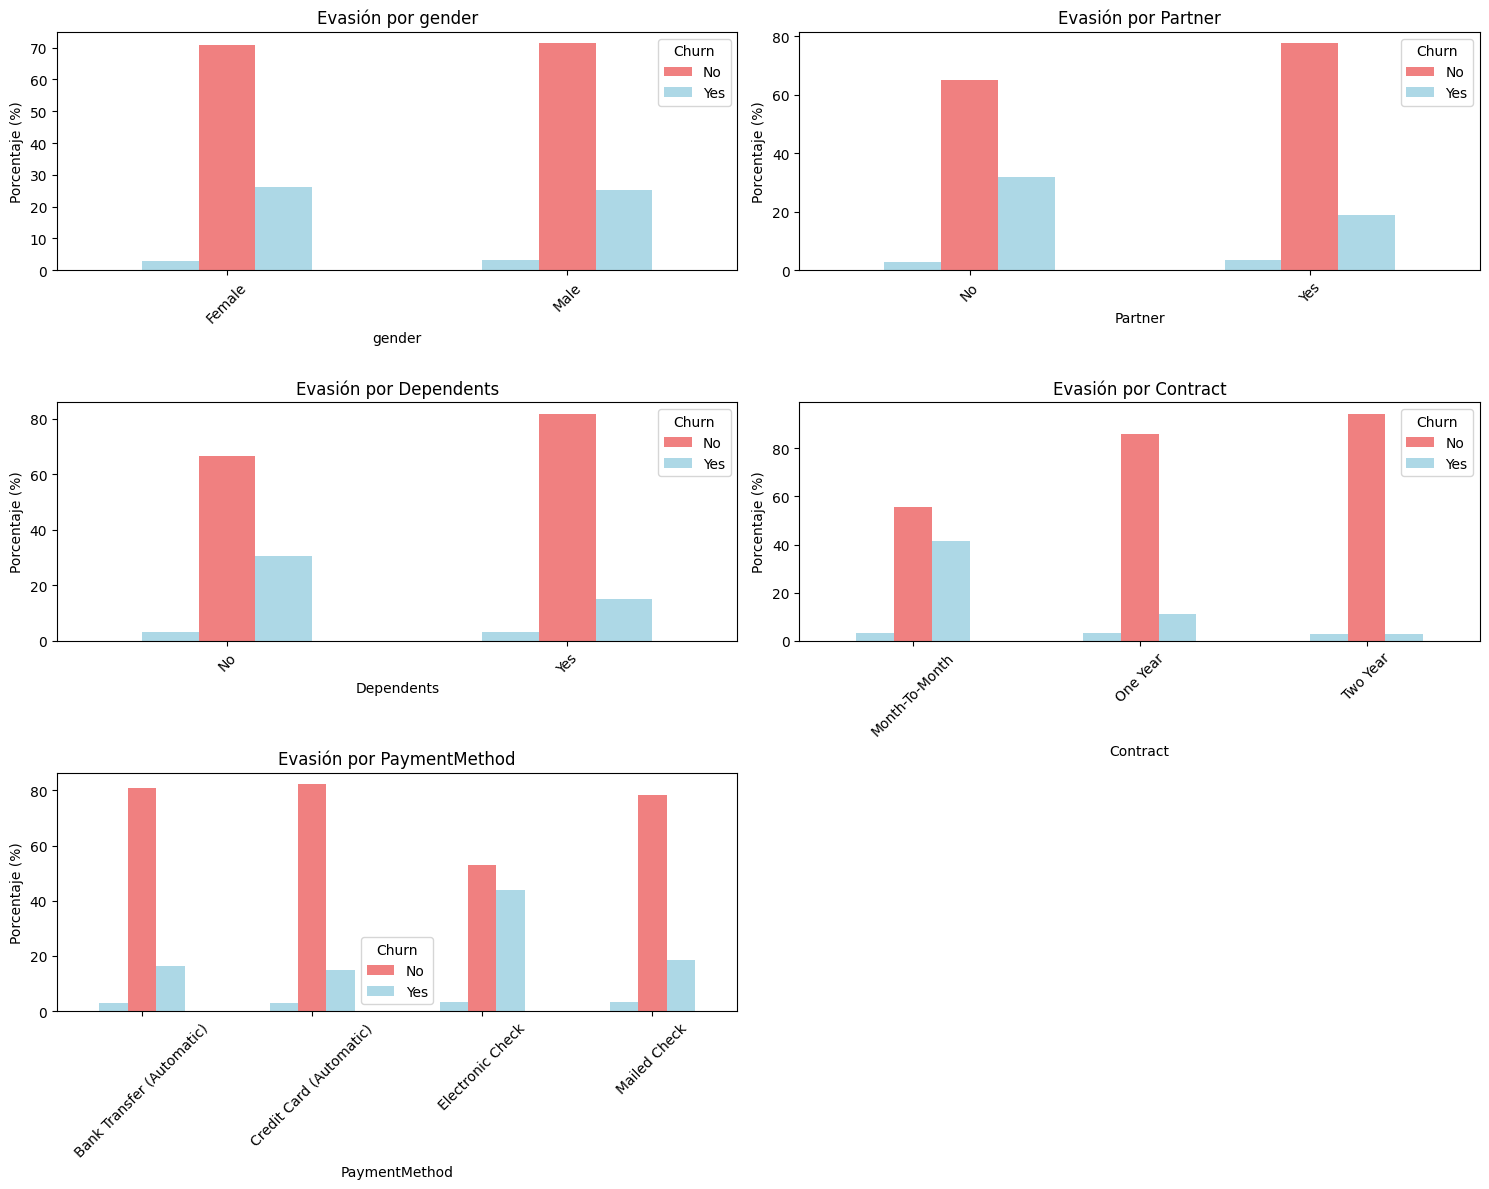


📊 ANÁLISIS DE EVASIÓN POR VARIABLES NUMÉRICAS

🔢 Análisis de tenure:
        count   mean    std  min   25%   50%   75%   max
Churn                                                   
        224.0  31.57  25.00  1.0   7.0  29.0  56.0  72.0
No     5174.0  37.57  24.11  0.0  15.0  38.0  61.0  72.0
Yes    1869.0  17.98  19.53  1.0   2.0  10.0  29.0  72.0

Promedio para No Churn: 37.57
Promedio para Yes Churn: 17.98
Diferencia: 19.59

🔢 Análisis de Charges.Monthly:
        count   mean    std    min    25%    50%    75%     max
Churn                                                          
        224.0  63.41  31.39  18.75  28.42  69.10  90.41  115.55
No     5174.0  61.27  31.09  18.25  25.10  64.43  88.40  118.75
Yes    1869.0  74.44  24.67  18.85  56.15  79.65  94.20  118.35

Promedio para No Churn: 61.27
Promedio para Yes Churn: 74.44
Diferencia: 13.18

🔢 Análisis de Charges.Total:
        count     mean      std    min     25%      50%      75%      max
Churn                        

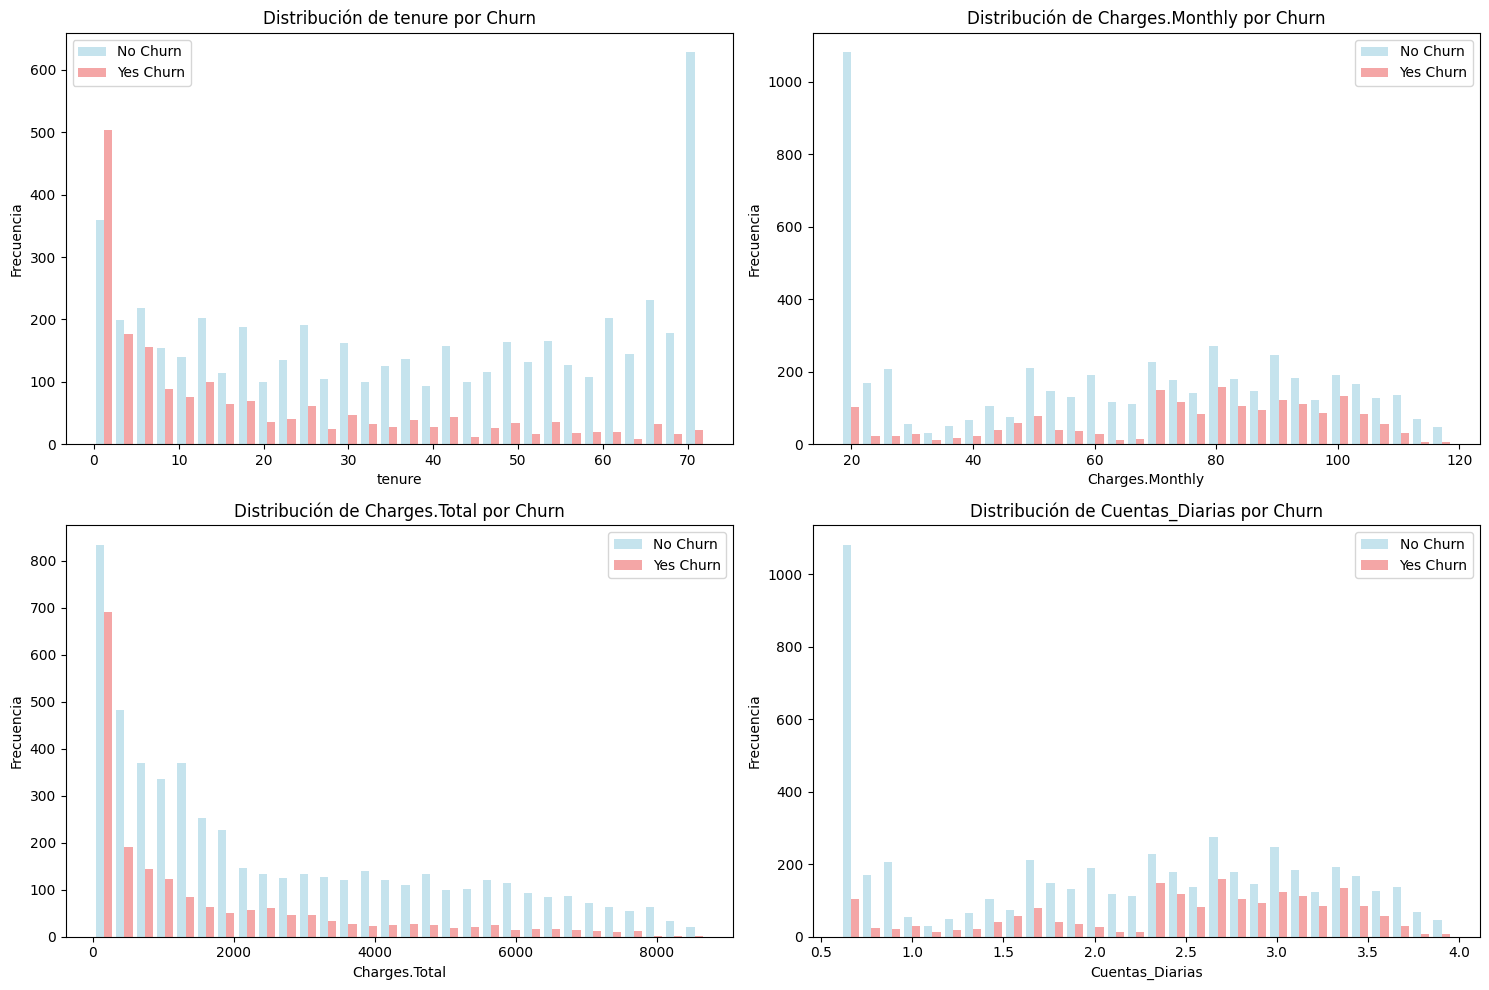


📊 MATRIZ DE CORRELACIÓN


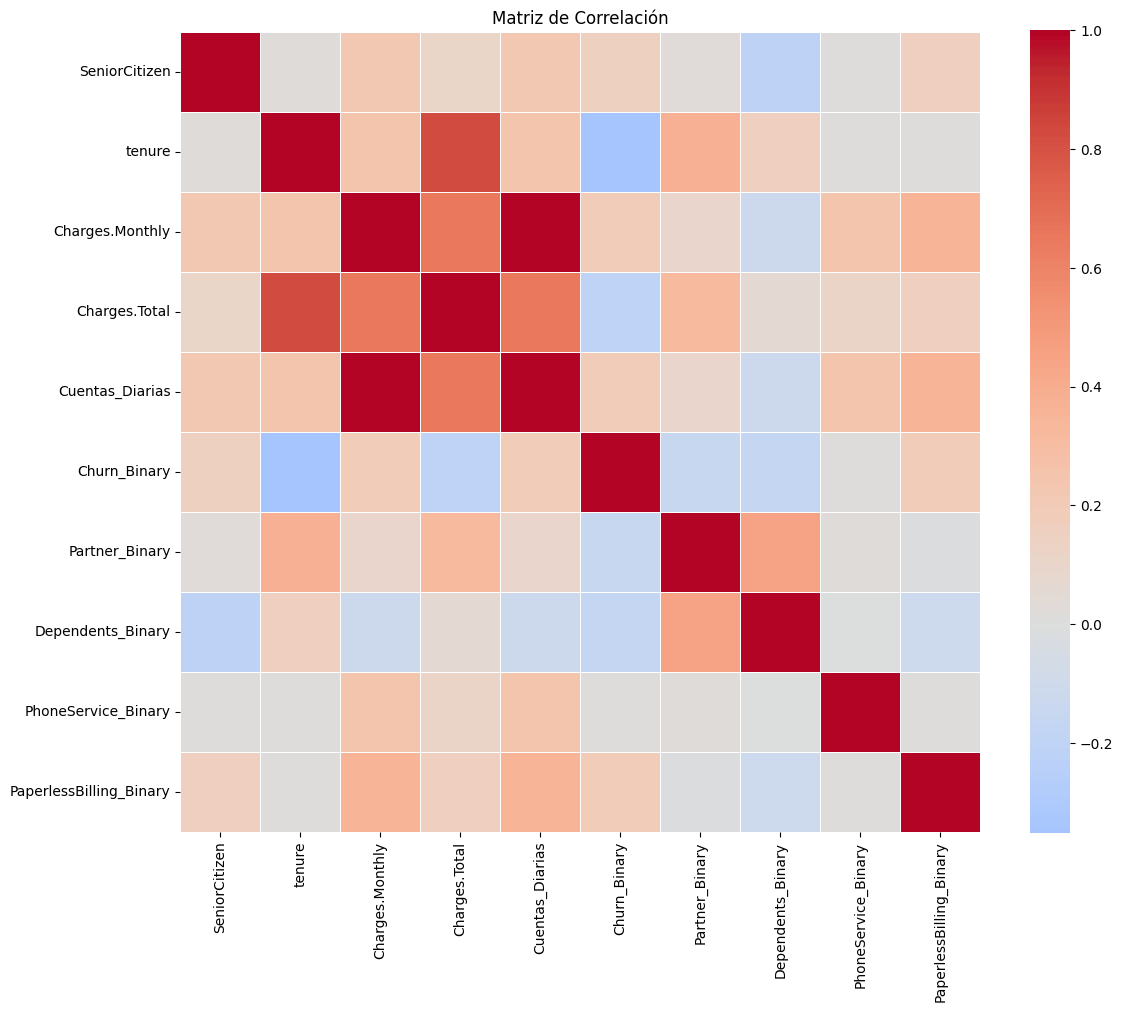


🎯 Variables más correlacionadas con Churn:
Churn_Binary               1.000000
Charges.Monthly            0.193356
Cuentas_Diarias            0.193356
PaperlessBilling_Binary    0.191825
SeniorCitizen              0.150889
PhoneService_Binary        0.011942
Partner_Binary            -0.150448
Dependents_Binary         -0.164221
Charges.Total             -0.199484
tenure                    -0.352229
Name: Churn_Binary, dtype: float64

📋 RESUMEN EJECUTIVO
📊 Total de clientes analizados: 7,267
📊 Clientes que abandonaron: 1,869
📊 Tasa de evasión: 25.72%

🔍 Características de clientes que abandonan:
   • Tenure promedio: 18.0 meses
   • Gasto mensual promedio: $74.44
   • Gasto total promedio: $1531.80
   • Tipo de contrato más común: Month-To-Month
   • Método de pago más común: Electronic Check

✅ Análisis completado exitosamente!
📋 Los datos están listos para modelado predictivo o análisis adicionales.


In [9]:
# CARGA Y ANÁLISIS

print("\n🔄 Iniciando análisis descriptivo...")

# 1. ANÁLISIS DESCRIPTIVO GENERAL
print("\n📊 ANÁLISIS DESCRIPTIVO GENERAL")
print("="*50)

# Estadísticas básicas
numeric_columns = df.select_dtypes(include=[np.number]).columns
print("\n📈 Estadísticas descriptivas:")
print(df[numeric_columns].describe().round(2))

# 2. DISTRIBUCIÓN DE EVASIÓN (CHURN)
print("\n📊 DISTRIBUCIÓN DE EVASIÓN")
print("="*40)

churn_dist = df['Churn'].value_counts()
churn_pct = df['Churn'].value_counts(normalize=True) * 100

print("\nDistribución absoluta:")
print(churn_dist)
print("\nDistribución porcentual:")
print(churn_pct.round(2))

# Visualización de distribución de evasión
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Gráfico de barras
churn_dist.plot(kind='bar', ax=axes[0], color=['lightblue', 'lightcoral'])
axes[0].set_title('Distribución de Evasión - Conteo')
axes[0].set_xlabel('Churn')
axes[0].set_ylabel('Número de Clientes')
axes[0].tick_params(axis='x', rotation=0)

# Gráfico de pastel
axes[1].pie(churn_pct.values, labels=churn_pct.index, autopct='%1.1f%%',
           colors=['lightblue', 'lightcoral'], startangle=90)
axes[1].set_title('Distribución de Evasión - Porcentaje')

plt.tight_layout()
plt.show()

# 3. ANÁLISIS POR VARIABLES CATEGÓRICAS
print("\n📊 ANÁLISIS DE EVASIÓN POR VARIABLES CATEGÓRICAS")
print("="*55)

categorical_vars = ['gender', 'SeniorCitizen', 'Partner', 'Dependents', 'PhoneService',
                   'MultipleLines', 'InternetService', 'OnlineSecurity', 'Contract',
                   'PaperlessBilling', 'PaymentMethod']

# Función para analizar evasión por variable categórica
def analyze_churn_by_category(df, column):
    if column not in df.columns:
        print(f"⚠️ Columna '{column}' no encontrada")
        return

    crosstab = pd.crosstab(df[column], df['Churn'], margins=True)
    crosstab_pct = pd.crosstab(df[column], df['Churn'], normalize='index') * 100

    print(f"\n🔍 {column}:")
    print("Conteo absoluto:")
    print(crosstab)
    print("\nPorcentaje por fila:")
    print(crosstab_pct.round(2))

    return crosstab, crosstab_pct

# Análisis para cada variable categórica
for var in categorical_vars[:5]:  # Primeras 5 variables
    analyze_churn_by_category(df, var)

# 4. VISUALIZACIONES POR VARIABLES CATEGÓRICAS
print("\n📈 Creando visualizaciones por variables categóricas...")

# Seleccionar variables principales para visualización
main_categorical = ['gender', 'Partner', 'Dependents', 'Contract', 'PaymentMethod']
available_categorical = [col for col in main_categorical if col in df.columns]

if available_categorical:
    n_cols = 2
    n_rows = (len(available_categorical) + 1) // 2

    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, n_rows * 4))
    axes = axes.flatten() if n_rows > 1 else [axes] if n_rows == 1 else axes

    for i, var in enumerate(available_categorical):
        if i < len(axes):
            crosstab_pct = pd.crosstab(df[var], df['Churn'], normalize='index') * 100
            crosstab_pct.plot(kind='bar', ax=axes[i], color=['lightblue', 'lightcoral'])
            axes[i].set_title(f'Evasión por {var}')
            axes[i].set_xlabel(var)
            axes[i].set_ylabel('Porcentaje (%)')
            axes[i].tick_params(axis='x', rotation=45)
            axes[i].legend(title='Churn')

    # Ocultar ejes vacíos
    for j in range(len(available_categorical), len(axes)):
        axes[j].set_visible(False)

    plt.tight_layout()
    plt.show()

# 5. ANÁLISIS POR VARIABLES NUMÉRICAS
print("\n📊 ANÁLISIS DE EVASIÓN POR VARIABLES NUMÉRICAS")
print("="*52)

numeric_vars = ['tenure', 'Charges.Monthly', 'Charges.Total', 'Cuentas_Diarias']
available_numeric = [col for col in numeric_vars if col in df.columns]

for var in available_numeric:
    print(f"\n🔢 Análisis de {var}:")

    # Estadísticas por grupo de churn
    stats_by_churn = df.groupby('Churn')[var].describe()
    print(stats_by_churn.round(2))

    # Test estadístico simple (diferencia de medias)
    no_churn = df[df['Churn'] == 'No'][var]
    yes_churn = df[df['Churn'] == 'Yes'][var]

    print(f"\nPromedio para No Churn: {no_churn.mean():.2f}")
    print(f"Promedio para Yes Churn: {yes_churn.mean():.2f}")
    print(f"Diferencia: {abs(no_churn.mean() - yes_churn.mean()):.2f}")

# 6. VISUALIZACIONES PARA VARIABLES NUMÉRICAS
print("\n📈 Creando visualizaciones para variables numéricas...")

if available_numeric:
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    axes = axes.flatten()

    for i, var in enumerate(available_numeric[:4]):
        # Histograma por grupo de churn
        no_churn_data = df[df['Churn'] == 'No'][var].dropna()
        yes_churn_data = df[df['Churn'] == 'Yes'][var].dropna()

        axes[i].hist([no_churn_data, yes_churn_data], bins=30, alpha=0.7,
                    label=['No Churn', 'Yes Churn'], color=['lightblue', 'lightcoral'])
        axes[i].set_title(f'Distribución de {var} por Churn')
        axes[i].set_xlabel(var)
        axes[i].set_ylabel('Frecuencia')
        axes[i].legend()

    plt.tight_layout()
    plt.show()

# 7. MATRIZ DE CORRELACIÓN
print("\n📊 MATRIZ DE CORRELACIÓN")
print("="*30)

# Crear DataFrame numérico para correlación
df_corr = df_transformed.select_dtypes(include=[np.number])

if len(df_corr.columns) > 1:
    correlation_matrix = df_corr.corr()

    plt.figure(figsize=(12, 10))
    sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
                square=True, linewidths=0.5)
    plt.title('Matriz de Correlación')
    plt.tight_layout()
    plt.show()

    # Correlaciones más altas con Churn
    if 'Churn_Binary' in correlation_matrix.columns:
        churn_correlations = correlation_matrix['Churn_Binary'].sort_values(ascending=False)
        print("\n🎯 Variables más correlacionadas con Churn:")
        print(churn_correlations.head(10))

# 8. RESUMEN EJECUTIVO
print("\n📋 RESUMEN EJECUTIVO")
print("="*25)

total_customers = len(df)
churned_customers = len(df[df['Churn'] == 'Yes'])
churn_rate = (churned_customers / total_customers) * 100

print(f"📊 Total de clientes analizados: {total_customers:,}")
print(f"📊 Clientes que abandonaron: {churned_customers:,}")
print(f"📊 Tasa de evasión: {churn_rate:.2f}%")

# Análisis rápido de características de los clientes que abandonan
if churned_customers > 0:
    churned_df = df[df['Churn'] == 'Yes']

    print(f"\n🔍 Características de clientes que abandonan:")
    print(f"   • Tenure promedio: {churned_df['tenure'].mean():.1f} meses")
    print(f"   • Gasto mensual promedio: ${churned_df['Charges.Monthly'].mean():.2f}")
    print(f"   • Gasto total promedio: ${churned_df['Charges.Total'].mean():.2f}")

    # Tipo de contrato más común en churned
    if 'Contract' in churned_df.columns:
        most_common_contract = churned_df['Contract'].mode().iloc[0]
        print(f"   • Tipo de contrato más común: {most_common_contract}")

    # Método de pago más común en churned
    if 'PaymentMethod' in churned_df.columns:
        most_common_payment = churned_df['PaymentMethod'].mode().iloc[0]
        print(f"   • Método de pago más común: {most_common_payment}")

print("\n✅ Análisis completado exitosamente!")
print("📋 Los datos están listos para modelado predictivo o análisis adicionales.")